In [148]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
import seaborn as sns
import time
from numpy.random import seed
seed(1)

tf.keras.utils.set_random_seed(1)


def plotCorrelationGraph(modelDataList, x="nodes_in_layers", y="accuracy"):
    x_arr = []
    y_arr = []
    for modelData in modelDataList:
        x_arr.append(modelData[x])
        y_arr.append(modelData[y])
    plt.ylabel(y)
    plt.xlabel(x)
    plt.plot(x_arr, y_arr)
    plt.show()

def cleanPredictions(predictions):
    _predictions = []
    for p in predictions:
        _predictions.append(np.argmax(p))
    return _predictions

def meassureAccuracy(predictions, y_test):
    test = predictions == y_test
    count = np.count_nonzero(test)
    accuracy = count/len(y_test)
    return accuracy

def printChosenParams(modelData, accuracy=True, weight_constraint=True, loss=True, use_cnn=True, nodes_in_layers=True, epochs=True, drop=True, add_dense_layer=True, time=True):
    string = ""
    if accuracy:
        string+="acc: {}, ".format('{0:.3f}'.format(modelData['accuracy']))
    if loss:
        string+="loss: {}, ".format('{0:.3f}'.format(modelData['loss']))
    if time:
        string+="time: {}, ".format('{0:.2f}'.format(modelData['elapsed_time']))
    if nodes_in_layers:
        string+="npl: {}, ".format(modelData['nodes_in_layers'])
    if epochs:
        string+="epochs: {}, ".format(modelData['epochs'])
    if drop:
        string+="drop: {}, ".format(modelData['drop'])
    if add_dense_layer:
        string+="extra_layers: {}, ".format(modelData['add_dense_layer'])
    if weight_constraint:
        string+="weight_constraint: {}, ".format(modelData['weight_constraint'])
    if use_cnn:
        cnn = ""
        if modelData['use_cnn']==1:
            cnn="yes"
        else:
            cnn="no"
        string+="convolutional layer: {}, ".format(cnn)
    
    print(string)


def onlyShowErrors(_cm):
    cm = _cm
    for i in range(0,10):
        cm[i][i]=0
    return cm


def mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, param_object_list):
    tested_models = []
    counter = 1
    for params in param_object_list:
        print("{}/{} {} started..".format(counter, len(param_object_list), params))
        weight=0
        if len(params)==6:
            weight=params[5]
        
        modelData = trainAndEvaluateModel(
            x_train, y_train, x_test, y_test,
            use_cnn=params[0].astype(int),
            nodes_in_layers=params[1].astype(int),
            epochs=params[2].astype(int),
            drop=params[3],
            add_dense_layer=params[4],
            weight_constraint=weight
        )
        tested_models.append(modelData)
        print("Done.Drop: {}, Acc: {}, time: {} ".format(modelData['drop'], '{0:.3f}'.format(modelData['accuracy']), modelData['elapsed_time']))
        counter+=1
        
    sortedList = sorted(tested_models, key=lambda d: d['accuracy'], reverse=True)
    return sortedList


def trainAndEvaluateModel(x_train, y_train, x_test, y_test, use_cnn=0,
                          nodes_in_layers=32,
                          epochs=10,
                          drop=0,
                          add_dense_layer=0,
                          weight_constraint=0):
    model = tf.keras.models.Sequential()
    if use_cnn==1:
        model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu',
                                         input_shape=(28, 28, 1)))
        model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(tf.keras.layers.Dropout(drop, seed=3))
        model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
    else:
        model.add(tf.keras.layers.Flatten(input_shape=(28,28)))
        model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu,))
        model.add(tf.keras.layers.Dropout(drop, seed=1))
    if weight_constraint!=0:
            model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu,
                                    kernel_constraint= tf.keras.constraints.max_norm(weight_constraint)))
    else:
            model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu))
    if add_dense_layer==1:
        model.add(tf.keras.layers.Dense(units=nodes_in_layers, activation=tf.nn.relu))
    model.add(tf.keras.layers.Dropout(drop, seed=2))
    model.add(tf.keras.layers.Dense(units=10, activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    
    model.fit(x_train, y_train, epochs=epochs, verbose=1)
    end = time.time()
    elapsed_time = end - start

    loss, accuracy = model.evaluate(x_test, y_test)
    
    returnValue = {}
    returnValue['description'] = "accuracy: {}, nodes_in_layers: {}, epochs: {}, drop: {}, time:{}, extra_layers: {},  use_cnn: {} ".format('{0:.3f}'.format(accuracy), nodes_in_layers, epochs, drop, '{0:.2f}'.format(elapsed_time), add_dense_layer, use_cnn)
    returnValue['elapsed_time'] = elapsed_time
    returnValue['accuracy'] = accuracy
    returnValue['loss'] = loss
    returnValue['drop'] = drop
    returnValue['use_cnn'] = use_cnn
    returnValue['epochs'] = epochs
    returnValue['add_dense_layer'] = add_dense_layer
    returnValue['nodes_in_layers'] = nodes_in_layers
    returnValue['weight_constraint'] = weight_constraint
    returnValue['predictions'] = cleanPredictions(model.predict(x_test))
    return returnValue

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = tf.keras.utils.normalize(x_train, axis=1)
x_test = tf.keras.utils.normalize(x_test, axis=1)

1/10 [0 8 1 0 0] started..
313/313 [==============================] - 0s 1ms/step
Done.Drop: 0, Acc: 0.878, time: 3.407589912414551 
2/10 [ 0 16  1  0  0] started..
313/313 [==============================] - 0s 1ms/step
Done.Drop: 0, Acc: 0.922, time: 3.2811920642852783 
3/10 [ 0 32  1  0  0] started..
313/313 [==============================] - 0s 1ms/step
Done.Drop: 0, Acc: 0.937, time: 3.7281432151794434 
4/10 [ 0 64  1  0  0] started..
313/313 [==============================] - 0s 1ms/step
Done.Drop: 0, Acc: 0.948, time: 4.1339123249053955 
5/10 [  0 128   1   0   0] started..
313/313 [==============================] - 0s 1ms/step
Done.Drop: 0, Acc: 0.961, time: 4.782177925109863 
6/10 [  0 200   1   0   0] started..
313/313 [==============================] - 1s 2ms/step
Done.Drop: 0, Acc: 0.965, time: 6.634226322174072 
7/10 [  0 250   1   0   0] started..
313/313 [==============================] - 1s 2ms/step
Done.Drop: 0, Acc: 0.964, time: 6.773885011672974 
8/10 [  0 300   1   0

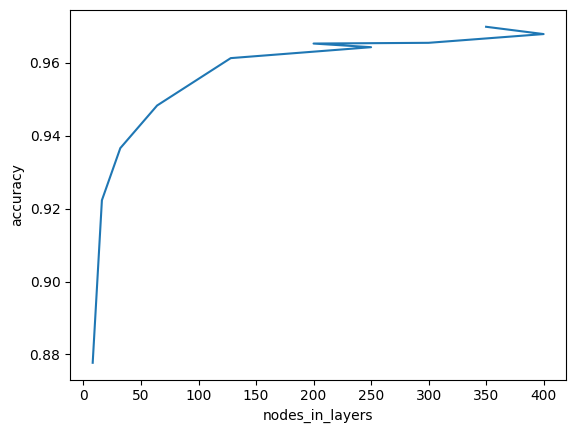

In [149]:
tf.keras.utils.set_random_seed(1)
seed(1)

###################################
## This block is testing neurons ##
###################################
#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
npltest_epochs = 6
parameters_to_test = np.array([[0, 8, npltest_epochs, 0, 0],
                               [0, 16, npltest_epochs, 0, 0],
                               [0, 32, npltest_epochs, 0, 0],
                               [0, 64, npltest_epochs, 0, 0],
                               [0, 128, npltest_epochs, 0, 0],
                               [0, 200, npltest_epochs, 0, 0],
                               [0, 250, npltest_epochs, 0, 0],
                               [0, 300, npltest_epochs, 0, 0],
                               [0, 350, npltest_epochs, 0, 0],
                               [0, 400, npltest_epochs, 0, 0],
                              ])
#Testing the significance of the number of neurons and if an extra layer adds to the accuracy
tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, parameters_to_test)

#Printing models from best to worst
for modelData in tested_models:
    printChosenParams(modelData, use_cnn=False, epochs=False, drop=False, time=False)

plotCorrelationGraph(tested_models)

In [103]:

###################################
## This block is testing dropout ##
###################################
nodes=128
epochs=5

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
d_parameters_to_test = np.array([[0, nodes, epochs, 0, 0],
                               [0, nodes, epochs, 0.1, 0],
                               [0, nodes, epochs, 0.2, 0],
                               [0, nodes, epochs, 0.3, 0],
                               [0, nodes, epochs, 0.4, 0],
                               [0, nodes, epochs, 0.5, 0],
                               [0, nodes, epochs, 0.6, 0],
                              ])
#Testing the significance of the number of neurons and if an extra layer adds to the accuracy
d_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, d_parameters_to_test)

#Printing models from best to worst
for modelData in d_tested_models:
    printChosenParams(modelData, use_cnn=False, epochs=False, time=False)




1/7 started..
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2663 - accuracy: 0.9229
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1076 - accuracy: 0.9664
Epoch 3/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0743 - accuracy: 0.9761
Epoch 4/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0544 - accuracy: 0.9820
Epoch 5/5
313/313 [==============================] - 1s 2ms/step
Done.Drop: 0.0, Acc: 0.965, time: 38.560314416885376 
2/7 started..
Epoch 1/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2932 - accuracy: 0.9135
Epoch 2/5
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1262 - accuracy: 0.9615
Epoch 3/5
1875/1875 [==============================] - 10s 5ms/step - loss: 0.0912 - accuracy: 0.9714
Epoch 4/5
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0723 - accuracy: 0.9775
Epoch 5/5
313/313 [=========================

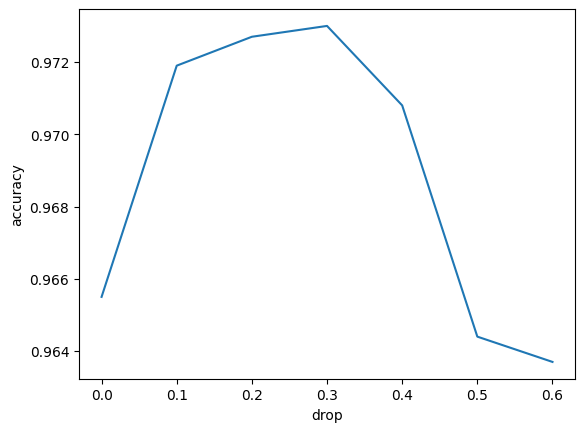

In [106]:
sortedList = sorted(d_tested_models, key=lambda d: d['drop'], reverse=False)
plotCorrelationGraph(sortedList, x="drop", y="accuracy")


In [107]:
###################################
## This block is testing epochs ##
###################################
nodes=128
drop=0.3

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
e_parameters_to_test = np.array([[0, nodes, 1, drop, 0],
                               [0, nodes, 5, drop, 0],
                               [0, nodes, 10, drop, 0],
                               [0, nodes, 15, drop, 0],
                               [0, nodes, 20, drop, 0],
                              ])
#Testing the significance of the number of neurons and if an extra layer adds to the accuracy
e_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, e_parameters_to_test)

#Printing models from best to worst
for modelData in e_tested_models:
    printChosenParams(modelData, use_cnn=False, epochs=False, time=False)



1/5 started..
313/313 [==============================] - 1s 2ms/step
Done.Drop: 0.3, Acc: 0.956, time: 7.125673532485962 
2/5 started..
Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3759 - accuracy: 0.8881
Epoch 2/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1809 - accuracy: 0.9463
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1409 - accuracy: 0.9579
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1228 - accuracy: 0.9624
Epoch 5/5
313/313 [==============================] - 1s 2ms/step
Done.Drop: 0.3, Acc: 0.972, time: 31.93875026702881 
3/5 started..
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3750 - accuracy: 0.8867
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1855 - accuracy: 0.9432
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1463 - accuracy: 0.9556
Epoch 4/10
1875/1875 [

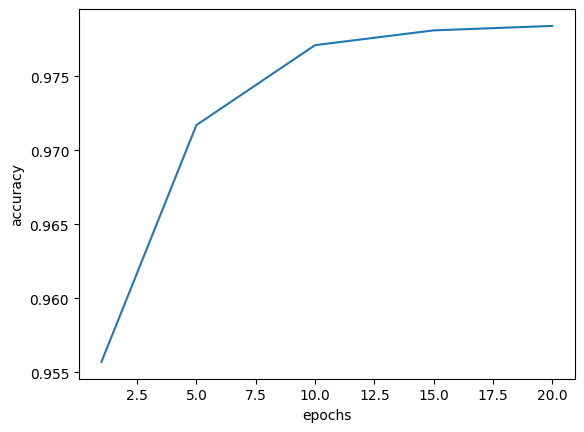

In [109]:
sortedList = sorted(e_tested_models, key=lambda d: d['epochs'], reverse=False)
plotCorrelationGraph(sortedList, x="epochs", y="accuracy")

In [111]:
################################################################
## This block is testing the addition of a convolutional layer##
################################################################
nodes=128
drop=0.3
epochs=10

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
c_parameters_to_test = np.array([[1, nodes, epochs, drop, 1],
                               [0, nodes, epochs, drop, 0]])

c_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, c_parameters_to_test)




1/2 started..
Epoch 1/10
1875/1875 [==============================] - 126s 67ms/step - loss: 0.1585 - accuracy: 0.9517
Epoch 2/10
1875/1875 [==============================] - 123s 66ms/step - loss: 0.0540 - accuracy: 0.9837
Epoch 3/10
1875/1875 [==============================] - 132s 70ms/step - loss: 0.0353 - accuracy: 0.9893
Epoch 4/10
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0259 - accuracy: 0.9919
Epoch 5/10
1875/1875 [==============================] - 123s 66ms/step - loss: 0.0188 - accuracy: 0.9941
Epoch 6/10
1875/1875 [==============================] - 121s 64ms/step - loss: 0.0150 - accuracy: 0.9955
Epoch 7/10
1875/1875 [==============================] - 123s 65ms/step - loss: 0.0123 - accuracy: 0.9965
Epoch 8/10
1875/1875 [==============================] - 124s 66ms/step - loss: 0.0117 - accuracy: 0.9963
Epoch 9/10
1875/1875 [==============================] - 124s 66ms/step - loss: 0.0099 - accuracy: 0.9969
Epoch 10/10
313/313 [====================

In [112]:
#Printing models from best to worst
for modelData in c_tested_models:
    printChosenParams(modelData, epochs=False)

acc: 0.986, loss: 0.085, time: 1247.96, npl: 128, drop: 0.3, extra_layers: 1.0, convolutional layer: yes, 
acc: 0.978, loss: 0.075, time: 54.69, npl: 128, drop: 0.3, extra_layers: 0.0, convolutional layer: no, 


In [117]:
################################################################
## Finally training using the discovered "best" values        ##
################################################################
nodes=250
drop=0.3
epochs=50

#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1]
c_parameters_to_test = np.array([[1, nodes, epochs, drop, 1]])

c_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, c_parameters_to_test)

1/1 started..
Epoch 1/50
1875/1875 [==============================] - 156s 83ms/step - loss: 0.1387 - accuracy: 0.9571
Epoch 2/50
1875/1875 [==============================] - 151s 80ms/step - loss: 0.0456 - accuracy: 0.9862
Epoch 3/50
1875/1875 [==============================] - 122s 65ms/step - loss: 0.0307 - accuracy: 0.9902
Epoch 4/50
1875/1875 [==============================] - 119s 63ms/step - loss: 0.0215 - accuracy: 0.9936
Epoch 5/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0175 - accuracy: 0.9947
Epoch 6/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0113 - accuracy: 0.9962
Epoch 7/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0114 - accuracy: 0.9970
Epoch 8/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0102 - accuracy: 0.9970
Epoch 9/50
1875/1875 [==============================] - 118s 63ms/step - loss: 0.0105 - accuracy: 0.9972
Epoch 10/50
1875/1875 [==================

In [118]:

printChosenParams(c_tested_models[0], epochs=False)

acc: 0.985, loss: 0.335, time: 29169.26, npl: 250, drop: 0.3, extra_layers: 1.0, convolutional layer: yes, 


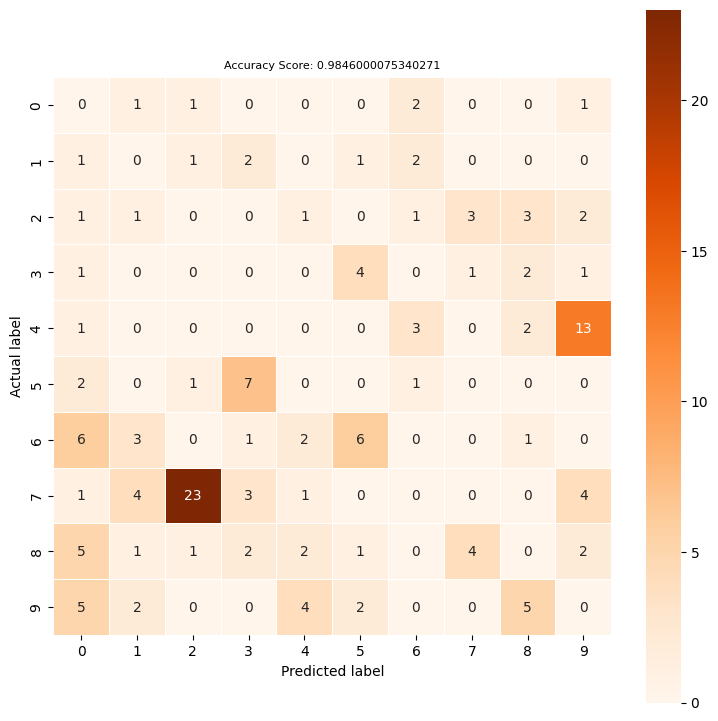

In [119]:
_modelData = c_tested_models[0]

predictions = _modelData['predictions']
cm = metrics.confusion_matrix(y_test, predictions)
error_cm = onlyShowErrors(cm)

plt.figure(figsize=(9,9))
sns.heatmap(error_cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Oranges');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(_modelData['accuracy'])
plt.title(all_sample_title, size = 8);

In [142]:
###################################
## This block is testing neurons ##
###################################
#[use_cnn = 0 or 1, nodes_in_layers, epochs, drop = float between 0 and 1, add_dense_layer = 0 or 1, weight_constraint]
weighttest_epochs = 6
weight_parameters_to_test = np.array([
                               [0, 128, weighttest_epochs, 0.3, 0, 2],
                               [0, 128, weighttest_epochs, 0.3, 0, 4],
                               [0, 128, weighttest_epochs, 0.3, 0, 6],
                               [0, 128, weighttest_epochs, 0.3, 0, 8],
                               [0, 128, weighttest_epochs, 0.3, 0, 10],
                               [0, 128, weighttest_epochs, 0.3, 0, 12],
                               [0, 128, weighttest_epochs, 0.3, 0, 14],
                               [1, 128, weighttest_epochs, 0.3, 1, 2],
                               [1, 128, weighttest_epochs, 0.3, 1, 4],
                               [1, 128, weighttest_epochs, 0.3, 1, 6],
                               [1, 128, weighttest_epochs, 0.3, 1, 8],
                               [1, 128, weighttest_epochs, 0.3, 1, 10],
                               [1, 128, weighttest_epochs, 0.3, 1, 12],
                               [1, 128, weighttest_epochs, 0.3, 1, 14],
                              ])
#Testing the significance of weight constraints
weight_tested_models = mapThen_trainAndEvaluateModel(x_train, y_train, x_test, y_test, weight_parameters_to_test)

#Printing models from best to worst
for modelData in weight_tested_models:
    printChosenParams(modelData, epochs=False, drop=False, time=False)

1/14 [  0.  128.    6.    0.3   0.    2. ] started..
Epoch 1/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3738 - accuracy: 0.8883
Epoch 2/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1834 - accuracy: 0.9451
Epoch 3/6
1875/1875 [==============================] - 9s 5ms/step - loss: 0.1422 - accuracy: 0.9566
Epoch 4/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1206 - accuracy: 0.9633
Epoch 5/6
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1078 - accuracy: 0.9667
Epoch 6/6
313/313 [==============================] - 1s 2ms/step
Done.Drop: 0.3, Acc: 0.973, time: 45.714627504348755 
2/14 [  0.  128.    6.    0.3   0.    4. ] started..
Epoch 1/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3754 - accuracy: 0.8874
Epoch 2/6
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1834 - accuracy: 0.9440
Epoch 3/6
1875/1875 [==============================] - 8s 4ms/step -

14
[14.0, 12.0, 10.0, 8.0, 6.0, 4.0, 2.0]
[14.0, 12.0, 10.0, 8.0, 6.0, 4.0, 2.0]


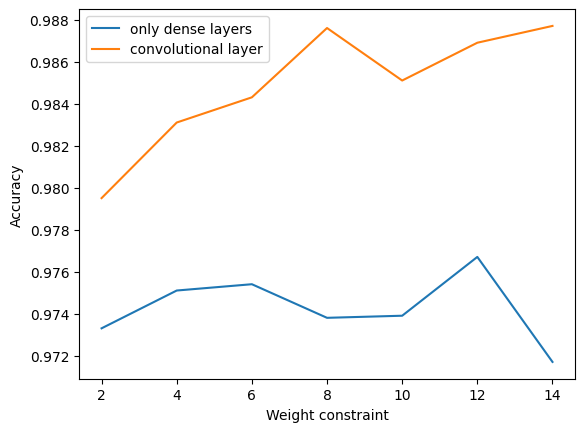

In [145]:
    x_arr = []
    y_arr = []
    x_arr_cnn = []
    y_arr_cnn = []
    sorted_cnn_List = sorted(weight_tested_models[:7], key=lambda d: d['weight_constraint'], reverse=True)
    sorted_dense_List = sorted(weight_tested_models[7:], key=lambda d: d['weight_constraint'], reverse=True)
    
    
    for modelData in sorted_cnn_List:
        x_arr_cnn.append(modelData['weight_constraint'])
        y_arr_cnn.append(modelData['accuracy'])
    for modelData in sorted_dense_List:
        x_arr.append(modelData['weight_constraint'])
        y_arr.append(modelData['accuracy'])                      
    
    print(len(weight_tested_models))
    print(x_arr)
    print(x_arr_cnn)
    
    
    plt.ylabel("Accuracy")
    plt.xlabel("Weight constraint")
    plt.plot(x_arr, y_arr, label="only dense layers")
    plt.plot(x_arr_cnn, y_arr_cnn, label="convolutional layer")
    plt.legend()
    plt.show()

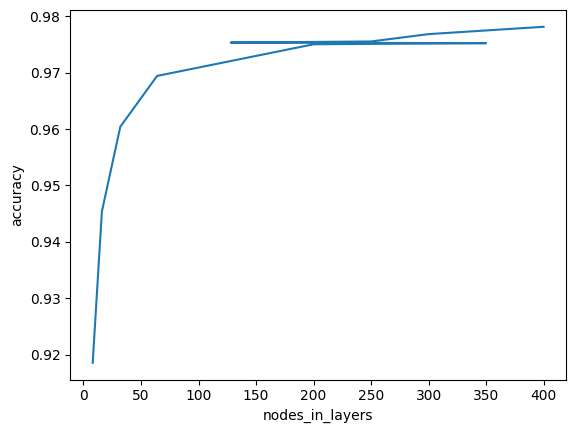

In [102]:
plotCorrelationGraph(tested_models)